<h1>Classifier Training</h1>
The filament picker uses a classifier to determine whether a part of the micrograph contains filaments or not. However, to properly train a classifier, you need to have a good feature generation pipeline. This will use the encoder from a trained autoencoder to speed up the process.

<h2>Early Imports</h2>
Python packages needed to setup everything up. Tensorflow will be imported later.

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import mrcfile
import dataset
from base64 import b64decode, b64encode
import pathlib
from sklearn.model_selection import train_test_split

In [3]:
def encode(arr):
    return b64encode(np.packbits(arr.flatten()).tobytes())

def decode(s):
    return np.unpackbits(np.frombuffer(b64decode(s), dtype='uint8'), count=196).astype(bool).reshape((-1, 14))

def decode_noreshape(s):
    return np.unpackbits(np.frombuffer(b64decode(s), dtype='uint8'), count=196).astype(bool)
#This assumes you will use the tool provided in the repo to label the image segments.

In [4]:
def normalizer(data):
    norm = (data - np.mean(data))/np.std(data)
    return (norm + 7.5)/15 #min is -7.5, max is +7.5 to achieve dynamic range
#7.5 and 29 give full range of numbers, but it's not really dynamic

In [5]:
db_agg = dataset.connect("sqlite:///holes/database_agg.db")
db_ice = dataset.connect("sqlite:///holes/database_noice.db")
db_fils = dataset.connect("sqlite:///holes/database_fils_prediction.db")
db_carbon = dataset.connect('sqlite:///holes/carbon.db')
#I tend to make a separate database for each condition I want to classify

In [6]:
mrcs = glob.glob("holes\*.mrc")
len(mrcs)

136

<h3>Reading in data</h3>

In [7]:
imgs = []
labels = []
num = 0
for file in mrcs:
    p = pathlib.Path(file)
    s_fil = db_fils['jpgs'].find_one(file=p.name)['data']
    if s_fil == "":
#         print('fil',p.name)
        continue
    s_agg = db_agg['jpgs'].find_one(file=p.name)['data']
    if s_agg == "":
#         print('agg',p.name)
        continue
    s_ice = db_ice['jpgs'].find_one(file=p.name)['data']
    if s_ice == "":
#         print('ice',p.name)
        continue
    s_car = db_carbon['jpgs'].find_one(file=p.name)['data']
    if s_car == "":
#         print('carbon',p.name)
        continue
    num += 1
    tmp_mrc = mrcfile.open(file)
    tmp_data = normalizer(tmp_mrc.data)
    tmp_data[tmp_data > 1] = 1
    arr_f = decode(s_fil)
    arr_a = decode(s_agg)
    arr_i = decode(s_ice)
    arr_c = decode(s_car)
    for i in range(14):
        for j in range(14):
            imgs.append(np.copy(tmp_data[i*64:(i+1)*64,j*64:(j+1)*64]))
            labels.append([arr_f[j,i], arr_a[j,i], arr_i[j,i], arr_c[j,i]])
#This code will only keep data that hass all 4 labels. Uncomment the print statement if you need to know what's being skipped.

In [9]:
imgs_np = np.array(imgs)
imgs_np.shape

(12544, 64, 64)

In [10]:
rotated = []
for i in range(1,4):
    rot_arr = np.rot90(imgs_np, k=i, axes=(1,2))
    rotated.append(rot_arr)
for r in rotated:
    imgs_np = np.append(imgs_np, r)
#data augmentation to help with training

In [11]:
imgs_np = imgs_np.reshape((-1, 64, 64, 1))
imgs_np.shape

(50176, 64, 64, 1)

In [12]:
s_min = np.min(imgs_np)
s_max = np.max(imgs_np)
print(s_min, s_max)
#double checking if data is between 0 and 1

0.007988358 1.0


In [23]:
labels_np = np.array(labels)
labels_np.shape

(12544, 4)

In [24]:
org = labels_np.copy()
for i in range(3):
    labels_np = np.append(labels_np,org)
#duplicating labels to match data augmentation
labels_np.shape

(200704,)

In [25]:
labels_np = labels_np.reshape((-1,4))
labels_np.shape

(50176, 4)

In [26]:
train_x, valid_x, train_label, valid_label = train_test_split(imgs_np, labels_np, test_size=0.2, random_state=42)
#Feel free to make the random state actually random. I fixed it so I could monitor changes with model architure changes.

<h3>Model Setup</h3>

In [27]:
import tensorflow as tf
import tensorflow.keras as keras

In [28]:
batch_size = 512 #trained on a Nvidia GeForce 2060 with 6GB, batch size can be changed if needed
# epochs = 50
inChannel = 1
x, y = 64, 64

In [29]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#this block is needed for some NVIDIA gpus to prevent memory errors. Might have gotten fixed in newer Tensorflow versions.

In [30]:
input_img = keras.Input(shape = (x, y, inChannel))

In [31]:
def batch_conv(input_img, channels, size=(3,3)):
    conv = keras.layers.Conv2D(channels, size, padding='same', use_bias=False)(input_img)
    conv = keras.layers.BatchNormalization()(conv)
    conv = keras.layers.ReLU()(conv)
    return conv

In [32]:
def fc_combined(input_img):
    #encoder
    #input = 64 x 64 x 1
    conv1 = batch_conv(input_img, 32) #64 x 64 x 32
    pool1 = keras.layers.MaxPool2D(pool_size=(2,2))(conv1) #32 x 32 x 32
    conv2 = batch_conv(pool1, 64) #32 x 32 x 64
    pool2 = keras.layers.MaxPool2D(pool_size=(2,2))(conv2) #16 x 16 x 64
    conv3 = batch_conv(pool2, 128) #16 x 16 x 128
    conv3_1 = batch_conv(conv3, 64, (1,1)) #16 x 16 x 64
    conv3_2 = batch_conv(conv3_1, 128) #16 x 16 x 128
    pool3 = keras.layers.MaxPool2D(pool_size=(2,2))(conv3_2) #8 x 8 x 128
    conv4 = batch_conv(pool3, 256) #8 x 8 x 256
    conv4_1 = batch_conv(conv4, 128, (1,1)) #8 x 8 x 128
    conv4_2 = batch_conv(conv4_1, 256) #8 x 8 x 256
    #classifier
    conv_c1 = batch_conv(conv4_2, 256) #8 x 8 x 256
    up1 = keras.layers.UpSampling2D((2,2))(conv_c1) #16 x 16 x 256
    cat = keras.layers.concatenate([up1,conv3_1]) #combines up1 and conv3_1 to get features from different LODs
    conv_class = batch_conv(cat, 128) #16 x 16 x 128
    flat = keras.layers.Flatten()(conv_class)
    den = keras.layers.Dense(128)(flat)
    den = keras.layers.LeakyReLU(alpha=0.1)(den)
    den = keras.layers.Dropout(0.3)(den)
    out = keras.layers.Dense(4, activation='sigmoid')(den) #classification layer
    return out

In [126]:
full_model = keras.models.Model(input_img, fc_combined(input_img))

In [34]:
old_model = keras.models.load_model('autoencoder_enFeatures_512b_stdver')
#load the previously trained autoencoder here

In [35]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [36]:
old_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        288       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256   

In [127]:
for l1, l2 in zip(full_model.layers[:28], old_model.layers[0:28]):
    l1.set_weights(l2.get_weights())
#sets the weight of the new model to match the encoder from the autoencoder.

In [128]:
for layer in full_model.layers[0:28]:
    layer.trainable = False
#sets those layers to be untrainable. In theory can be undone to improve results later on, but I never saw an increase myself

In [129]:
full_model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.001, epsilon=0.0001), metrics=['accuracy'])

In [40]:
full_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   288         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [130]:
classify_train = full_model.fit(train_x, train_label, batch_size=batch_size, epochs=5, verbose=1, validation_data=(valid_x, valid_label))
#this model is prone to overfitting. It only takes 5-10 epochs to train it. Keep an eye on validation loss and accuracy to determine if it's overfitting
#it might take a few tries to get the best model possible. This is mainly due to it trying to learn multiple categories at once
#you're looking to get high accuracy in the category you are mainly interested in (ex. filaments)
#this potentially can be tweaked, but this is version used for publication

Epoch 1/5
79/79 [==============================] - 6s 81ms/step - loss: 0.4833 - accuracy: 0.6192 - val_loss: 0.4233 - val_accuracy: 0.6240
Epoch 2/5
79/79 [==============================] - 6s 78ms/step - loss: 0.2535 - accuracy: 0.7441 - val_loss: 0.2741 - val_accuracy: 0.6284
Epoch 3/5
79/79 [==============================] - 6s 78ms/step - loss: 0.2237 - accuracy: 0.7633 - val_loss: 0.2438 - val_accuracy: 0.6477
Epoch 4/5
79/79 [==============================] - 6s 78ms/step - loss: 0.2015 - accuracy: 0.7803 - val_loss: 0.2311 - val_accuracy: 0.6683
Epoch 5/5
79/79 [==============================] - 6s 78ms/step - loss: 0.1936 - accuracy: 0.7830 - val_loss: 0.2063 - val_accuracy: 0.8187


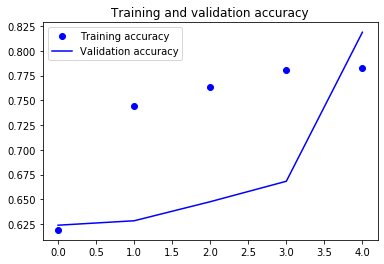

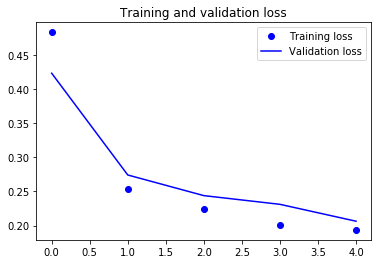

In [131]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

<h3>Model validation</h3>

In [132]:
pred = full_model.predict(valid_x, batch_size=512)

In [133]:
pred_round = np.round(pred).astype(bool)
#converts to bool output

In [134]:
print('fil', np.sum(valid_label[:,0] == pred_round[:,0])/len(valid_label))
print('agg', np.sum(valid_label[:,1] == pred_round[:,1])/len(valid_label))
print('ice', np.sum(valid_label[:,2] == pred_round[:,2])/len(valid_label))
print('car', np.sum(valid_label[:,3] == pred_round[:,3])/len(valid_label))
#print the accuracy for each label type

fil 0.8043045037863691
agg 0.9667198086887206
ice 0.9797728178557195
car 0.8938820247110403


Spot check

[ True False False False]
[False False False False]
[2.0312625e-01 1.8047400e-04 9.7343877e-02 6.6316465e-04]


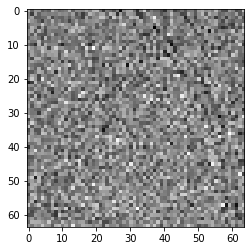

In [147]:
num = 300
plt.imshow(valid_x[num].reshape(64,64), cmap='gray')
print(valid_label[num])
print(pred_round[num])
print(pred[num])

Histogram of results

(array([2814., 1642., 1167.,  906.,  786.,  665.,  568.,  483.,  473.,
         532.]),
 array([2.2809660e-10, 9.9980667e-02, 1.9996133e-01, 2.9994202e-01,
        3.9992267e-01, 4.9990335e-01, 5.9988403e-01, 6.9986469e-01,
        7.9984534e-01, 8.9982605e-01, 9.9980670e-01], dtype=float32),
 <a list of 10 Patch objects>)

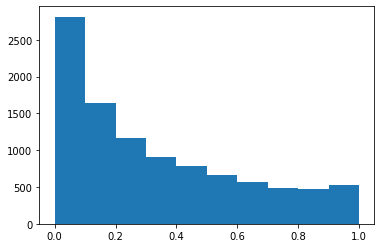

In [148]:
plt.hist(pred[:,0]) #fil
#this one tends to be more continuous. Might need to setup a different threshold than 0.5 to get best results. Final picker uses the value as is and considers it a probability instead

(array([8741.,  267.,  142.,   91.,   90.,   78.,   76.,   83.,  134.,
         334.]),
 array([1.2822982e-29, 9.9947914e-02, 1.9989583e-01, 2.9984373e-01,
        3.9979166e-01, 4.9973956e-01, 5.9968746e-01, 6.9963539e-01,
        7.9958332e-01, 8.9953119e-01, 9.9947912e-01], dtype=float32),
 <a list of 10 Patch objects>)

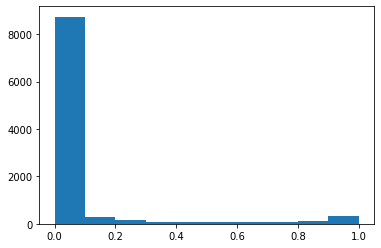

In [149]:
plt.hist(pred[:,1]) #agg

(array([7336.,  206.,   86.,   52.,   58.,   48.,   52.,   76.,  102.,
        2020.]),
 array([3.3108149e-06, 1.0000298e-01, 2.0000266e-01, 3.0000231e-01,
        4.0000197e-01, 5.0000167e-01, 6.0000134e-01, 7.0000100e-01,
        8.0000067e-01, 9.0000033e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

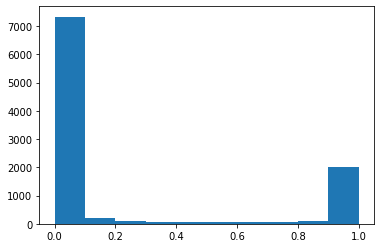

In [150]:
plt.hist(pred[:,2]) #ice

(array([6311.,  572.,  366.,  297.,  273.,  276.,  297.,  353.,  429.,
         862.]),
 array([0.        , 0.09997386, 0.19994773, 0.2999216 , 0.39989546,
        0.49986932, 0.5998432 , 0.69981706, 0.7997909 , 0.8997648 ,
        0.99973863], dtype=float32),
 <a list of 10 Patch objects>)

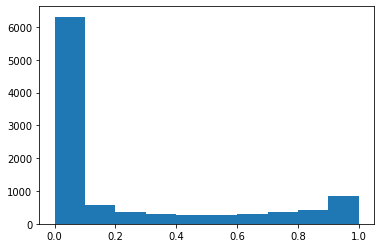

In [151]:
plt.hist(pred[:,3]) #carbon

Testing on a full image

In [153]:
mrc = mrcfile.open("new_holes/20jan13b_atlas2_00047gr_00017sq_v02_00006hl.mrc")

In [155]:
big_test = normalizer(mrc.data)
big_test[big_test > 1] = 1

1.0


In [158]:
big_test_v = np.zeros((14*14,64,64), dtype='float32')
for i in range(14):
    for j in range(14):
        n = i*14 + j
        big_test_v[n] = big_test[64*j:64*(j+1),64*i:64*(i+1)]
big_test_v = big_test_v.reshape(-1, 64, 64, 1)
big_test_v.shape

(196, 64, 64, 1)

In [159]:
pred = full_model.predict(big_test_v)

In [171]:
big_pred = np.zeros((64*14,64*14), dtype='float32')
for i in range(14):
    for j in range(14):
        n = i*14 + j
        if pred[n][0] > 0.3: #change this to different categories and thresholds
            big_pred[64*j:64*(j+1),64*i:64*(i+1)] = mrc.data[64*j:64*(j+1),64*i:64*(i+1)]*.5
        else:
            big_pred[64*j:64*(j+1),64*i:64*(i+1)] = mrc.data[64*j:64*(j+1),64*i:64*(i+1)]

(-0.5, 895.5, 895.5, -0.5)

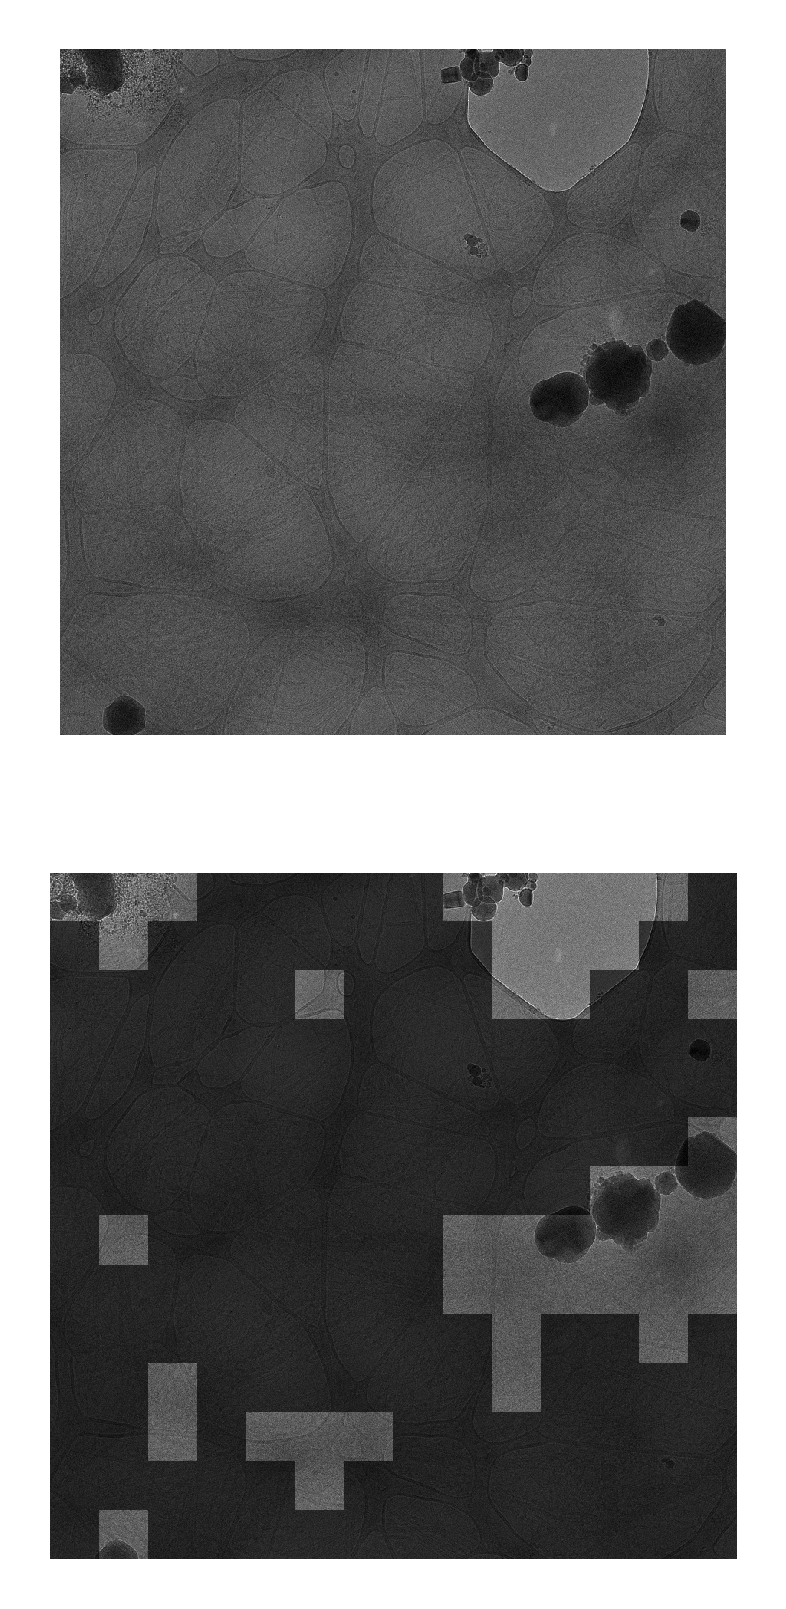

In [172]:
fig, ax = plt.subplots(2,1)
ax = ax.flatten()
fig.set_dpi(500)
ax[0].imshow(mrc.data[0:64*16,0:14*64], cmap='gray')
ax[0].axis('off')
ax[1].imshow(big_pred, cmap='gray')
ax[1].axis('off')

If happy with the results, save the model.

In [ ]:
full_model.save("full_model_all_filters_v3")